## Preprocessing version 3
### Details
this version 
- uses all data
- has validation split
- uses pretrained embedding

In [1]:
import csv
import sys
from multiprocessing import Pool
from tqdm import tqdm_notebook as tqdm
import json
import os
import blingfire
from joblib import Parallel, delayed

UNK = "[UNK]"
BOS = "[CLS]"
EOS = "[SEP]"
PAD = "[PAD]"

def tokenize(s, omit=[]):
    s = s.lower()
    for t in omit:
        s = s.replace(t, '')
    ts = [BOS] + blingfire.text_to_words(s).split() + [EOS]
    return ts
def tokenize_add_vocab(sents, vocab, omit=[]):
    sent_toks = []
    for s in sents:
        toks = tokenize(s, omit)
        for t in toks:
            vocab[t] = vocab.get(t, 0) + 1
        sent_toks.append(toks)
    return sent_toks
def tokens_to_ids(tokens, vocab):    
    return [vocab.get(t, vocab[UNK]) for t in tokens]

class Processor:
    def __init__(self, threads):
        self.score = []
        self.summary = []
        self.text = []
        self.n_worker = threads        
        self.size = 0

    def make_vocab_and_ids(self, cutoff, verbose=True):
        vocab = {UNK:99999, PAD:99999}
        summary_tok = tokenize_add_vocab(self.summary, vocab, self.omit)
        if verbose:
            print("sum tok done")
        text_tok = tokenize_add_vocab(self.text, vocab, self.omit)
        if verbose:
            print("text tok done")
        vocab = sorted(vocab.items(), key=lambda x: -x[1])[:cutoff]
        vocab = {a:i for i,(a,b) in enumerate(vocab)}
        self.vocab = vocab
        
        summary_gen = tqdm(summary_tok)
        text_gen = tqdm(text_tok)
        
        if self.n_worker < 2:
            self.summary_ids = [tokens_to_ids(t, vocab) for t in summary_gen]
            self.text_ids = [tokens_to_ids(t, vocab) for t in text_gen]
        else:
            #with Pool(self.n_worker) as p:
            #    chunksize = 100                
                #self.summary_ids = list(p.imap(tokens_to_ids, summary_gen))
                #self.text_ids = list(p.imap(tokens_to_ids, text_gen))
            self.summary_ids = Parallel(n_jobs=self.n_worker, backend='multiprocessing')(delayed(tokens_to_ids)(tokens, vocab) for tokens in summary_gen)
            self.text_ids = Parallel(n_jobs=self.n_worker, backend='multiprocessing')(delayed(tokens_to_ids)(tokens, vocab) for tokens in text_gen)
            
        if verbose:
            print("vocab and id done")
        
    def __len__(self):
        return self.size
    
    def dump(self, name, vocabname):
        seqdata = {"text":self.text_ids, "summary":self.summary_ids, "score":self.score}
        json.dump(seqdata, open(name, 'w'))
        if vocabname is not None:
            json.dump(self.vocab, open(vocabname, 'w'))
    
    @staticmethod
    def readcsv(input_file, quotechar="\""):
        """Reads a comma separated value file."""
        with open(input_file, "r", encoding="utf-8") as f:
            reader = csv.reader(f, delimiter=",", quotechar=quotechar)
            lines = []
            for line in reader:
                if sys.version_info[0] == 2:
                    line = list(unicode(cell, 'utf-8') for cell in line)
                lines.append(line)
            return lines
        
class FoodProcessor(Processor):
     def __init__(self, name, threads):
        super(FoodProcessor, self).__init__(threads)
        lines = self.readcsv(name)

        for d in lines[1:]:
            #self.score.append(int(d[6]) > 3) # convert to 0/1
            self.score.append(int(d[6])-1)
            self.summary.append(d[8])
            self.text.append(d[9].strip("\""))
        self.size = len(self.text)   
            
class IMDBProcessor(Processor):
    def __init__(self, dirname, threads):
        super(IMDBProcessor, self).__init__(threads)
        
        posdir = os.path.join(dirname, 'pos')
        negdir = os.path.join(dirname, 'neg')
        
        self.score = []
        self.text = []
        self.summary = []
        self.omit = ["<br />"]
        
        for lb,subdir in enumerate(['neg','pos']):
            subdir = os.path.join(dirname, subdir)
            for entry in os.listdir(subdir):
                fname = os.path.join(subdir, entry)
                with open(fname, 'r') as f:
                    t = f.read().strip()
                self.score.append(lb)
                self.text.append(t)
                self.summary.append(t)
        
        self.size = len(self.text)
            
class BBCProcessor(Processor):
     def __init__(self, name, threads):
        super().__init__(threads)
        lines = self.readcsv(name)
        labeldict = {}
        for lb, txt in lines[1:]:
            labeldict[lb] = labeldict.get(lb, len(labeldict))
            self.score.append(labeldict[lb]) # convert to 0/1
            self.summary.append(txt)
            self.text.append(txt)
        self.size = len(self.text)   

In [2]:
# take a break

In [3]:
p = IMDBProcessor("data/aclImdb/train", 1)

In [4]:
p.make_vocab_and_ids(cutoff=100000)

sum tok done
text tok done


vocab and id done


In [5]:
p.dump("data/IMDB/data.json", "data/IMDB/vocab.json")

In [6]:
index = 999
vocab_inv = {a:b for b,a in p.vocab.items()}

print([vocab_inv[i] for i in p.text_ids[index]])

['[CLS]', 'i', 'remember', 'this', 'show', 'being', 'on', 'the', 'television', 'when', 'i', 'was', 'a', 'kid', 'back', 'in', 'the', 'early', '1990s', ',', 'and', 'there', 'was', 'this', 'rage', 'about', 'kids', 'with', 'goofy', 'leotards', 'doing', 'kung', 'fu', 'on', 'one', 'another', 'and', 'riding', 'around', 'in', 'plastic', 'dinosaurs', '.', 'it', 'was', 'called', 'power', 'rangers', '.', 'i', 'remember', 'that', 'little', 'kids', 'would', 'go', 'around', 'hitting', 'each', 'other', 'and', 'then', 'the', 'shirts', 'and', 'the', 'stuff', 'from', 'the', 'show', 'was', 'banned', 'in', 'many', 'school', 'districts', 'all', 'over', 'the', 'country', 'because', 'this', 'show', 'taught', 'kids', 'how', 'to', 'fight', 'each', 'other', 'in', 'solving', 'their', 'differences', '.', 'i', 'never', 'really', 'thought', 'of', 'this', 'as', 'a', 'show', ',', 'especially', 'when', 'better', 'shows', 'like', 'the', 'tick', 'were', 'playing', 'on', 'fox', 'kids', '.', 'most', 'older', 'teens', 'alw

(array([8.590e+02, 2.367e+03, 6.637e+03, 4.545e+03, 2.724e+03, 1.881e+03,
        1.373e+03, 1.001e+03, 7.740e+02, 5.950e+02, 4.740e+02, 3.660e+02,
        2.800e+02, 2.140e+02, 1.830e+02, 1.670e+02, 1.240e+02, 9.500e+01,
        8.700e+01, 8.300e+01, 7.300e+01, 5.800e+01, 1.100e+01, 9.000e+00,
        2.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  13.  ,   68.06,  123.12,  178.18,  233.24,  288.3 ,  343.36,
         398.42,  453.48,  508.54,  563.6 ,  618.66,  673.72,  728.78,
         783.84,  838.9 ,  893.96,  949.02, 1004.08, 1059.14, 1114.2 ,
        1169.26, 1224.32, 1279.38, 1334.44, 1389.5 , 1444.56, 1499.62,
        1554.68, 1609.74, 1664.8 , 1719.86, 1774.92, 1829.98, 1885.04,
        1940.1 , 1995

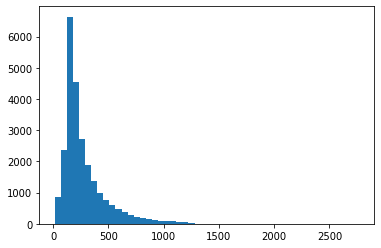

In [8]:
lens = [len(x) for x in p.text_ids]
import matplotlib.pyplot as plt
plt.hist(lens, bins=50)

In [9]:
import numpy as np
print(np.mean(lens), np.std(lens))

276.00016 203.18075617531892
